### Preparing the dataset

In [2]:
import os
import tarfile
import urllib 
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt 

urls = ["http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", "http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"]

def download_and_extract(data_dir, download_dir):
  for url in urls: 
    target_file = url.split('/')[-1]
    if target_file not in os.listdir(download_dir):
      print('Downloading', url)
      urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
      tf = tarfile.open(url.split('/')[-1])
      tf.extractall(data_dir)
    else:
      print('Already downloaded', url)

def cats_vs_dogs_annotations(file_path):
  annotations = {}

  with open(file_path, 'r') as f:
    rows = f.read().splitlines()
  
  for i, row in enumerate(rows):
    image_name, _, _, _ = row.split(' ')
    image_name += '.jpg'
    if image_name[0].lower() != image_name[0]:
      class_name = 'cat'
    else:
      class_name = 'dog'
    annotations[image_name] = class_name
  return annotations, i + 1

def display_examples(x, y, p, images, index_to_class):
  print('Displaying first 8 examples')
  if len(images) < 8:
    print('Neet at least 8 examples')
    return None 
  
  plt.figure(figsize=(12, 8))
  for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    gt = int(np.squeeze(y[i]) < 0.5)
    pred = int(np.squeeze(p[i]) > 0.5)
    col = 'green' if gt == pred else 'red'
    plt.xlabel(index_to_class[pred], color=col)
  return plt 

download_and_extract('data', '.')

### Data Pre-processing
We will now be doing some Pre-Processing with our Dataset, and prepare the Data for our modelling and Final Analysis. We can start this formally but first, let's ensure that we have got Tensorflow installed on our environment and a GPU available for our Data Modelling.

In google colab, you can enable GPU by going to Runtime and clicking on, Change Runtime. You can enable the GPU option by clicking on Hardware Accelerator and clicking GPU.

In [4]:
%matplotlib inline 

data_dir = 'data/'
if not os.path.isdir(data_dir):
  os.mkdir(data_dir)

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow version: 2.9.2
Is using GPU? True


Since this is a binary classification problem we will be using annotations to point to our samples in the Dataset. Our Dataset has been downloaded onto the Data directory so now we will be writing some code to properly annotate Dog and Cat pictures. If you take a look at your Dataset, you will find that there are annotations and images. In the annotations, you can see a list which is your list of files and trainval and test which holds our Training and Testing Dataset. These contain Image Names which we will be using to annotate our Dataset.

We will now write some code to map the Index to Class and vice versa and we will write some extra code to extract our annotations and print the count of Training Examples and Testing Examples:

In [20]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_annot, count_train = cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot, count_test = cats_vs_dogs_annotations('data/annotations/test.txt')

print('Training examples count:', count_train)
print('Test examples count:', count_test)


Training examples count: 3680
Test examples count: 3669


Basically, the Class to Index and Index to Class, means that the pictures annotated as 0 belongs to a Cat while the ones annotated as 1 belongs to a Dog. Now that we have extracted the annotations, let's move next to get the images as well.

Now we will write some code to get a Random Batch from our images. We will be processing our Dataset here using Keras. The primary purpose of Random Batch is to take the annotation dictionary and return some randomly selected examples from our Dataset.

In [9]:
image_dir = 'data/images'

def get_random_batch(annot, batch_size=4):
  all_keys = list(annot.keys())
  total_examples = len(all_keys)
  indices = np.random.choice(range(total_examples), batch_size)
  x = np.zeros((batch_size, 128, 128, 3))
  y = np.zeros((batch_size, 1))
  images = []

  for i, index in enumerate(indices):
    image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, all_keys[index]), target_size=(128, 128))
    images.append(image)
    arr = tf.keras.preprocessing.image.img_to_array(image)
    arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
    arr = np.expand_dims(arr, axis=0)
    x[i] = arr
    y[i] = class_to_index[annot[all_keys[index]]]
  return x, y, images


### What did we do here?

* We took the arguments in our function as the Annotation Dictionary and the Batch Size. The Annotation Keys are converted into a list and the length is stored.

* We used Numpy's Random function to return some randomly chosen examples from our Dataset.

* The images are stored onto an Array x where we pass the batch size as the parameter and take 128x128x3 as the Image Size. The reason why we are using this is because we wil be using MobileNet as our baseline model and this is one of the Image Options that are available for us and is the smallest size the Image is available for.

* We will store the Class Output onto the Array y where we store either 1 or 0 which will be our Class Output.

* Now we will run a loop to return the Image Examples and not just the Labels and Annotations. We will extract the Image from the Images directory and passing the key index of Image.

* We can use the Preprocessing Helper Function defined in Keras by calling in tf.keras.preprocessing.image and then passing the Image Path and the Channel size which is 128x128x3.

* We will use another Keras Function to convert the Image to a Numpy Array and for this operation, we will use tf.keras.preprocessing.image.img_to_array just because our model is expecting data in a multi-dimensional format.

* We can further preprocess our input dataset by using another Keras function tf.keras.applications.mobilenet_v2.preprocess_input. This is primarily done to change the Mean Standard Deviation of our Dataset so that it is easy to achieve the Global Minima.

* At last, we can write some code to expand our dimensions to return the batch size according to the size that we have passed in the function. Finally, we will pass the array to x and the keys to y. We can then return both x and y and end the function block.

Now that we have written the function to return a random batch, let's try it out. We will write a small block of code where we will call our previously defined function and display the examples using the functions that we defined earlier:


Displaying first 8 examples


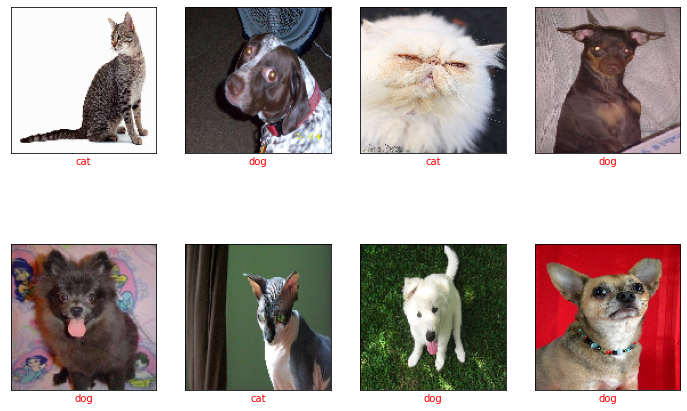

In [21]:
x, y, images  = get_random_batch(train_annot, batch_size=8)

display_examples(x, y, y, images, index_to_class).show()

### Data Modelling
MobileNet is a popular Pre-Trained Model that has been trained on the ImageNet Dataset. Training a model akin to MobileNet, which has millions of parameters is computationally expensive and takes a lot of time and to save the time and increase the accuracy manifold, we will be relying on Transfer Learning for our purpose

Let's download the MobileNetV2 from Keras and we have to specify a few paramaters as well. Let's write this simple block of code:

In [24]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False,
    input_shape=(128, 128, 3),
    pooling='avg',
    weights='imagenet'
)

9406464/9406464 [==============================] - 0s 0us/step


We are setting include_top to False so that we don't modify any of the existing layers and effectively freeze them. We will specify the input shape since this is a Binary Classification problem and MobileNet can classify well up to 1000 Classes. We will also convert our pooling to average so that a Four-Dimensional tensor can be converted to a Two-Dimensional one. We will also specify the pretrained weights, which is the main part here.

We will get the whole MobileNet architecture summarized here and take no issues if you don't understand it much. We will be leveraging this architecture to develop our own model. We have got here more than two million trainable parameters and now we will be creating our own model on top of this. So let's get started with some code:

In [25]:
def create_model():
  model = tf.keras.models.Sequential(
      [
          mnet,
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(1, activation='sigmoid')
      ]
  )

  model.layers[0].trainable = False 
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  return model

model = create_model() 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


* We will be using a Sequential Model from Keras. This will define how the model will be laid down in Stack Layers.
* We will set the MobileNet architecture that we downloaded as our first layer and then we will set the Dropout Layer with 0.5 as the Dropout Rate.
* Our Final Layer will be a Dense Layer and we will use Sigmoid as our Activation Function here.
* We will then set the Trainable Layers to False so that we don't train them from our side and then we will pass a model.compile() function with a Binary Crossentropy as our Loss Function and an Adam Optimizer.
* We will then move forward to creating the Model and printing the Model Summary.

Once we have done these steps, we can see the Model Summary on the Screen. We can see that we have some 1,281 Trainable Parameters and the rest, from MobileNet, is converted to Non-Trainable. We will now write some code before we kickstart our Model and Start the Training Process.

We will first write a Data Generator function which can take in the Batch Size and Annotatin as function parameters and pass the Data. We can use this in our Fit Generator Function. We will write a loop which can fetch random bathes from our Dataset.

Then we will fit our Model by using the fit_generator() function and we will be using the data_generator() function where we will pass the batch size and Training Annotation. We will also define the Validation Data and pass the batch size and Testing Annotation. We will also define the Validation Steps and Steps per epoch and we will run one epoch. We are running the whole model for one epoch because we already have pre-trained weights and our model needs to go through all the examples just once.

In [31]:
def data_generator(batch_size, annot):
  while True:
    x, y, _ = get_random_batch(annot, batch_size)
    yield (x,y)
  batch_size = 32
  steps_per_epoch = int(len(list(train_annot.keys())) / batch_size)
  validation_steps = int(len(list(test_annot.keys())) / batch_size)
  print('Steps per epoch:', steps_per_epoch)
  print('Validation steps:', validation_steps)

  %%time
  _ = model.fit_generator(
      data_generator(batch_size, train_annot),
      validation_data = data_generator(batch_size, test_annot),
      steps_per_epoch = steps_per_epoch,
      validation_steps = validation_steps,
      epochs = 1
  )

We are using the %%time Magic Function to time the Code Cell. This might take a few seconds or minutes to configure and train and we can see that have achieved a Validation Accuracy of 94.35%

### Predictions
Now that we have completed our Training Part and the Validation Accuracy would be anything above 90%. The main advantage of using Transfer Learning and a Pre-trained Model is that we don't need to train our model for long. We can just have Pre-trained weights and we can configure the input layers as per our requirements and the Dataset that we have in hand. So, let's visualize the results and see what we have got. We will write a small block of code to get some random examples on which we can predict whether the picture belongs to a Cat or a Dog using our trained model.

In [32]:
x, y, images = get_random_batch(test_annot, batch_size=8)

1/1 [==============================] - 8s 8s/step
Displaying first 8 examples


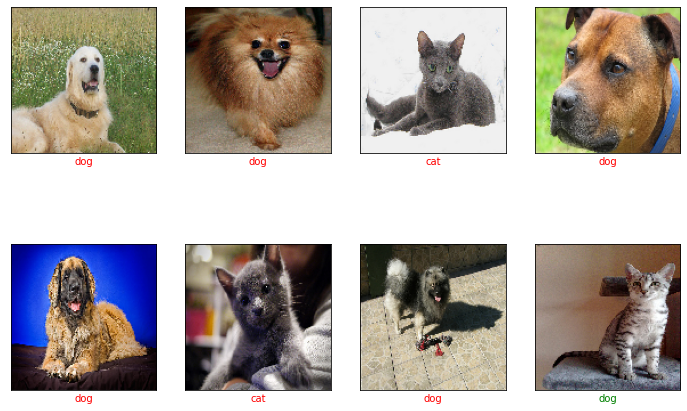

In [33]:
preds = model.predict(x)
display_examples(x, y, preds, images, index_to_class).show()